<a href="https://colab.research.google.com/github/OlyaMizonova/training-with-ml/blob/main/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
def toDF(filename):
  diction=unpickle(filename)
  del diction[b'batch_label']
  del diction[b'filenames']
  diction['labels'] = diction[b'labels']
  del diction[b'labels']
  diction['data'] = diction[b'data']
  del diction[b'data']
  df1=pd.DataFrame(diction['data'])
  df2=pd.DataFrame(diction['labels'])
  df2=df2.rename(columns={0:'type'})
  df=pd.concat([df1,df2],axis=1)
  return df

In [ ]:
df1=toDF('data_batch_1')
df2=toDF('data_batch_2')
df3=toDF('data_batch_3')
df4=toDF('data_batch_4')
df5=toDF('data_batch_5')
dfTest=toDF('test_batch')

In [ ]:
df=df1
#df=pd.concat([df1,df2,df3,df4,df5],axis=0)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoded_categories = encoder.fit_transform(df[['type']]).toarray()
encoder1 = OneHotEncoder()
encoded_categories1 = encoder1.fit_transform(dfTest[['type']]).toarray()

In [ ]:
encoded_df = pd.DataFrame(encoded_categories, columns=('airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'))
encoded_df1 = pd.DataFrame(encoded_categories1, columns=('airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'))

In [ ]:
df=df.drop(['type'],axis=1)
dfTest=dfTest.drop(['type'],axis=1)

In [ ]:
def imag(arr):
  width = 32
  height = 32
  channels = 3
  img = np.zeros((height, width, channels), dtype=np.uint8)
  i=0
  for y in range(img.shape[0]):
    for x in range(img.shape[1]):
      img[y][x][0] = arr[i]
      img[y][x][1] = arr[i+1024]
      img[y][x][2] = arr[i+2048]
      i+=1
  plt.figure(figsize=(2,2))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

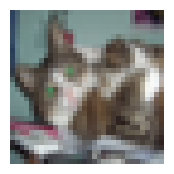

In [ ]:
imag(df.iloc[331].to_numpy())

In [ ]:
Y_train = encoded_df.values #метки классов
X_train = df.values
Y_test = encoded_df1.values #метки классов
X_test = dfTest.values

In [ ]:
BATCH_SIZE = 32
torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_Y_train = torch.from_numpy(Y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_Y_test = torch.from_numpy(Y_test).type(torch.LongTensor) # data type is long

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_Y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_Y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
torch_X_train = torch_X_train.view(-1, 3, 32,32).float()#я понимаю что делает view,
torch_X_test = torch_X_test.view(-1,3,32,32).float()#но не понимаю, какие у нас тут должны быть новые размеры :(
# print(torch_X_train.shape)
# print(torch_X_test.shape)
# print(torch_Y_train.shape)
# print(torch_Y_test.shape)

torch.Size([10000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])
torch.Size([10000, 10])
torch.Size([10000, 10])


In [ ]:
train = torch.utils.data.TensorDataset(torch_X_train,torch_Y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_Y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)#change kernel size from 3 to 4
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
def fit(model, train_loader):
  train_losses = []
  train_accuracies = []

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  model.train()
  for epoch in range(2):
      running_loss = 0.0
      correct = 0
      total = 0
      predicted=0
      for i, data in enumerate(train_loader, 0):
          inputs, labels = data
          labels = labels.to(torch.float)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          total += labels.size(0)

          y_pred = np.array(outputs.data)
          y_true = np.array(labels.data)

          a=inputs.size()[0]
          b=labels.size()[1]
          for i in range(a):
             max_el = 0.
             indMaxEl=0
             for j in range (b):
               if(y_pred[i][j]>max_el):
                 max_el = y_pred[i][j]
                 indMaxEl=j
             for j in range (b):
               y_pred[i][j]=0.
             y_pred[i][indMaxEl]=1.
             if((y_pred[i]==y_true[i]).all()):
               predicted+=1

          #predicted = torch.max(outputs.data, 1)
          #print(predicted)
          # if (torch.all(predicted == labels)):
          #     correct += 1
          # else:
          #     correct += 0

      train_losses.append(running_loss / len(train_loader))
      train_accuracies.append(predicted / total)
      print(f'Epoch {epoch} loss: {running_loss / len(train_loader)}')
  return train_losses, train_accuracies

Epoch 0 loss: 1.6255123283916388
Epoch 1 loss: 1.1458115817639773


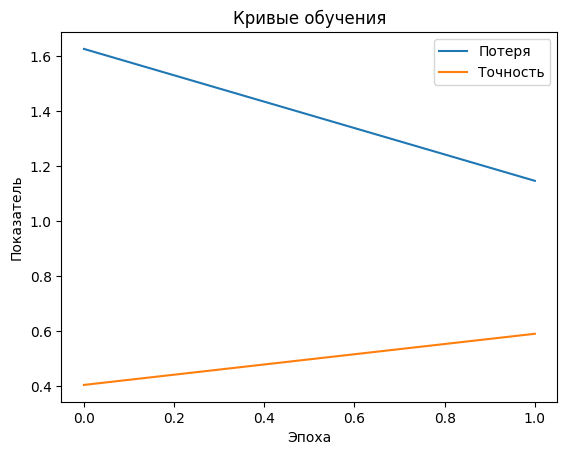

In [ ]:
train_losses, train_accuracies = fit(ResNet18(), train_loader)
plt.plot(train_losses, label="Потеря")
plt.plot(train_accuracies, label="Точность")
plt.xlabel("Эпоха")
plt.ylabel("Показатель")
plt.legend()
plt.title("Кривые обучения")
plt.show()

In [ ]:
def evalute(model, test_loader):
  model.eval()
  y_pred_all=[]
  y_true_all=[]
  for i, data in enumerate(test_loader, 0):
      inputs, labels = data
      outputs = model(inputs)

      y_pred = np.array(outputs.data)
      y_true = np.array(labels.data)

      a=inputs.size()[0]
      b=labels.size()[1]
      for i in range(a):
        max_el = 0.
        indMaxEl=0
        for j in range (b):
          if(y_pred[i][j]>max_el):
            max_el = y_pred[i][j]
            indMaxEl=j
        for j in range (b):
          y_pred[i][j]=0.
          y_pred[i][indMaxEl]=1.
        # if((y_pred[i]==y_true[i]).all()):
        #   predicted+=1
      y_pred_all.extend(y_pred)
      y_true_all.extend(y_true)
  report = classification_report(y_true_all, y_pred_all)
  return report

In [ ]:
test_report = evalute(ResNet18(), test_loader)
print(test_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.09      0.78      0.16      1000
           2       0.05      0.07      0.06      1000
           3       0.14      0.03      0.05      1000
           4       0.50      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

   micro avg       0.09      0.09      0.09     10000
   macro avg       0.08      0.09      0.03     10000
weighted avg       0.08      0.09      0.03     10000
 samples avg       0.09      0.09      0.09     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
